## 1. Installing Modules

#### Installing facebook forecasting algorithm "prophet"

In [ ]:
#!pip install pystan==2.19.1.1
#!pip install prophet

In [ ]:
# OR
!conda install gcc

In [ ]:
!conda install -c conda-forge prophet

## 2. Importing modules

In [123]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import os
from IPython.display import clear_output as co
from sklearn.preprocessing import LabelEncoder as le

In [124]:
#from prophet import Prophet

## Defining functions

In [125]:
def load_series(path='series/'):
    filenames = os.listdir(path)
    series, cnt, n_files = {}, 0, len(filenames)
    freq = range(1, n_files, 10)
    for filename in filenames:
        cnt+=1
        if cnt in freq: print(f'Files loaded: {cnt}/{n_files}'); co(wait=True)
        series[filename[:-4]] = pd.read_csv(path+filename, index_col=0)
    print(f'Done! Loaded {n_files} files.')
    return series

class preprocess:
    
    def __init__(self):
        self.name = 'preprocessing functions class'
    
    #### Extract predictive and target variables
    def get_xy(self, data, target='area', fill_na=0):
        ## 1. Extraindo variáveis preditivas
        X = data.drop(target, 1)
        ## 2. Extraindo Variável Álvo
        Y = data[target].copy()
        #### Substituição de Valores Vazios para Variável Alvo
    #     Y[Y.isna()] = fill_na
        return X,Y

    #### Label Encode pandas dataframe
    def label_encode(self, X, base=None):
        if type(base)==type(None): base = X
        X_lab = X.copy()
        for column in X:
            X_lab[column] = le().fit(base[column]).transform(X[column])
        return X_lab

    ## Separação das amostras para treinamento e teste
    def split_ts(self, x, y, col='year', horizon=2):
    #     periods = x[col].sort_values().iloc[:len(x)-horizon]
        msk = x[col].isin([42, 43])
        return [x[msk==False], x[msk], y[msk==False], y[msk]]

    
    ### Train test split of time series by key
    def custom_tts(self, key):
        x, y = self.get_xy(series[key], target='area', fill_na=0)
        x_lab = self.label_encode(x[['year']], base=data)
        return self.split_ts(x_lab, y, col='year', horizon=2)
    
    def clean_series(self, series, train_min=1, drop_start_zeros=True, keep_all_zero=True):
        clean_series = {}
        test_empty = []
        excluded_test_index = []
        n_total = len(series)
        n_values_total = 0
        n_values_test = 0
        n_values_train = 0
        n_series = 0
        n_series_empty = 0
        n_series_test_empty = 0
        n_series_train_min_empty = 0
        n_values = 0
        n_test_empty_total = 0
        n_train_empty_total = 0
        n_non_empty_values = 0
        n_train_zeros = 0

        cnt, freq = 0, range(1, n_total, 10)
        for key in list(series.keys()):
            cnt+=1
            if cnt in freq: print(f'Cleaned series: {cnt}/{n_total}'); co(wait=True)

            msk = series[key]['year'].isin(['01/01/2016', '01/01/2017'])
            test = series[key][msk]
            train = series[key][msk==False]

            n = len(series[key])
            n_empty = series[key][target].isna().sum()
            n_test_empty = test[target].isna().sum()
            n_train_empty = train[target].isna().sum()

            cond1 = n_test_empty == len(test)
            cond2 = n_train_empty > (len(train) - train_min) # if number of training samples is greater than specified minimum.

            n_values_total += n
            n_values_test += len(test)
            n_values_train += len(train)

            n_series_empty += n==n_empty
            n_test_empty_total+=n_test_empty
            n_train_empty_total+=n_train_empty
            n_series_test_empty += cond1
            n_series_train_min_empty += cond2

            if cond1 or cond2:
                n_series+=1
                n_values+=len(series[key])
                n_non_empty_values+=(len(series[key]) - n_empty)
                excluded_test_index.extend(test[test[target].isna()==False].index.tolist())

            else:
                n_values+=n_empty
                clean_series[key] = series[key].dropna(subset=['area'])
                if drop_start_zeros:
                    if keep_all_zero:
                        test_msk = clean_series[key]['year'].isin(['01/01/2016', '01/01/2017'])
                        train_msk = test_msk==False
                        isNotZero = (clean_series[key][train_msk]['area']!=0).tolist()
                        if sum(isNotZero)!=0:
                            testset = clean_series[key][test_msk]
                            trainset_cut = clean_series[key][train_msk].iloc[isNotZero.index(True):]
                            clean_series[key] = pd.concat([trainset_cut, testset])
                            n_train_zeros+=(sum(train_msk)-len(trainset_cut))
                            
                            
        print('Values Count:')
        print( pd.Series(
            [n_total, n_values_total, n_values_test, n_values_train],
            index=['n_total', 'n_values_total', 'n_values_test', 'n_values_train'])
        )
        print(); print('Excluded count:')
        print(
            pd.Series([
                n_series, n_series_empty, n_series_test_empty, n_series_train_min_empty,
                n_values, n_values-n_non_empty_values, n_test_empty_total, n_train_empty_total,
                n_non_empty_values, len(excluded_test_index), n_train_zeros
            ],
            index=[
                'series', 'series_empty', 'series_test_empty', f'series_train_min_<_{train_min}',
                'values', 'values_empty', 'test_empty', 'train_empty',
                'non_empty_values', 'non_empty_test_values', 'n_train_zeros'
            ])
        )
        return clean_series, excluded_test_index

---
## 3. Carregando Dados

In [126]:
target = 'area'
prods = [
    'Rice', 'Beans', 'Cassava',
    'Corn', 'Soy', 'Sorghum',
    'Cocoa', 'Palm oil', 'Açaí',
    'Livestock', 'Others-temporary', 'Others-permanent'
]

In [20]:
df = pd.read_csv('data/historical-database.csv', sep=';')

In [20]:
df.head(3)

,year,city_code,product_type,product,"destinated_area,"
0,01/01/1974,960b4f2c94a2fb2c,temporary,Others,"0,"
1,01/01/1974,746cc42bfb8f6b62,temporary,Others,"0,"
2,01/01/1974,6cce2bf873870afc,temporary,Others,"0,"


---
# 2. Data cleaning

### Formatação de dados

In [10]:
data = df.copy()

#### Formatação do nome da coluna da variável alvo
data.rename(columns={'destinated_area,': 'area'}, inplace=True)
#### Identificação de células vazias
data['area'].replace(',', np.nan, inplace=True)
#### Conversão da variável alvo para float
data['area'] = data['area'].str.replace(',', '.').astype(float)
### Salvando dados limpos
#data.to_csv('data/historical-database-clean.csv', index=False)

#### Loading formatted data

In [127]:
data = pd.read_csv('data/historical-database-clean.csv')
data.head(3)

,year,city_code,product_type,product,area
0,01/01/1974,960b4f2c94a2fb2c,temporary,Others,0.0
1,01/01/1974,746cc42bfb8f6b62,temporary,Others,0.0
2,01/01/1974,6cce2bf873870afc,temporary,Others,0.0


### Extração de séries temporais por combinação de cidade, produto e tipo

In [ ]:
cities = data['city_code'].unique()
products = data['product'].unique()
ts_i = {}
for city_code in cities:
    city_ts = data[ data['city_code']==city_code ]
    for product in products:
        prod_ts = city_ts[ city_ts['product']==product ].sort_values('year').copy()
        if len(prod_ts):
            if product=='Others':
                for prod_type in ['temporary', 'permanent']:
                    prod_type_ts = prod_ts[ prod_ts['product_type']==prod_type ].copy()
                    if len(prod_type_ts):
                        key = product+'-'+prod_type
                        ts_i[city_code+'-'+key] = prod_type_ts
            else:
                key = product
                ts_i[city_code+'-'+key] = prod_ts
ts_dict = ts_i

#### Salvando séries isoladas
#for key in ts_dict.keys():
#    ts_dict[key].to_csv(f'series/{key}.csv', index=True)

#### Loading isolated series

In [129]:
raw_series = load_series()

Done! Loaded 1712 files.


---
# Data processing

### 2.0 Dealing with missing values:

1. Excluindo séries.
    * Excluindo séries para as quais a variável alvo está vazia para 2016 e 2017.
    * Excluindo séries para as quais a variável alvo com zero entradas no conjunto de treinamento (até 2015) (35 found).
2. Excluding first years.
    * Excluindo vazios ou zeros até "n" anos. (Análises univariadas)
    * Excluindo vazios ou zeros até "ni" anos para cada série. (Análises multivariadas)
3. Excluding/filling missing values.
    * Excluindo entradas vazias (opcional).
    * Preenchendo entradas vazias (opcional). 

In [119]:
series, excluded_test_index = preprocess().clean_series(raw_series, train_min=1, drop_start_zeros=True)
keys = list(series.keys())

Values Count:
n_total            1712
n_values_total    73744
n_values_test      3424
n_values_train    70320
dtype: int64

Excluded count:
series                     605
series_empty               442
series_test_empty          582
series_train_min_<_1       465
values                   40936
values_empty             39035
test_empty                1198
train_empty              37837
non_empty_values          1901
non_empty_test_values       35
n_train_zeros             4796
dtype: int64


### Concatening series

In [120]:
LE = le().fit(data['year'])
X_full = pd.concat([series[key].set_index('year')[target] for key in keys], 1).sort_index()
X_full.columns = keys; X_full.index = LE.transform(X_full.index.values)

In [121]:
#X_full.to_csv('data/series.csv', index=False)

### Setting pandas datetime index

In [9]:
dt_series = {}
for key in keys:
    dt_series[key] = series[key].set_index(pd.DatetimeIndex(series[key]['year'].astype('datetime64[Y]')))[target]

#### 2.1 Extracting test data (2016 and 2017)

In [24]:
## Fit and retrieve score for all series by model
Y_e = []
for key in keys:
    x_t, x_e, y_t, y_e = preprocess().custom_tts(key)
    Y_e.append(y_e)
Y_e = pd.concat(Y_e)#.reset_index(drop=True)
data_e = data.loc[Y_e.index].copy()

#### 2.3 Extracting test index for each type-product combination

In [27]:
prod_indexes = {}
for prod in prods:
    if prod not in ['Sorghum', 'Açaí']:
        if '-' in prod: 
            product, prod_type = prod.split('-')
        else:
            product = prod
        df = data_e[data_e['product']==product].copy()        
        if '-' in prod: 
            df = df[df['product_type']==prod_type]
        prod_indexes[prod] = df.index.copy()

#### 2.3 Extracting test index for each product_type

In [28]:
prodtype_indexes = {}
for prodtype in ['temporary', 'permanent', 'pasture']:
    df = data_e[data_e['product_type']==prodtype].copy()        
    prodtype_indexes[prodtype] = df.index.copy()

---
## 5. Data Exploration

In [4]:
target='area'

#### By type-product

In [51]:
data.groupby(['product', 'product_type']).describe()

area                                          \
                         count          mean            std        min   
product   product_type                                                   
Açaí      permanent      291.0   1686.230241    5245.467590   3.000000   
Beans     temporary     3414.0    565.310193     990.800160   0.000000   
Cassava   temporary     3848.0   2270.173857    3824.356790   1.000000   
Cocoa     permanent     1801.0   1109.669628    2933.876503   0.000000   
Corn      temporary     3739.0   2110.839262    4579.408423   1.000000   
Livestock pasture       4752.0  98051.332823  141783.939141  33.074823   
Others    permanent     6292.0    582.808964    1468.537558   0.000000   
          temporary     6292.0    133.125238     722.437937   0.000000   
Palm oil  permanent      521.0   2735.932821    4201.624180   0.000000   
Rice      temporary     3418.0   1646.812171    3698.659558   0.000000   
Sorghum   temporary        7.0   4435.000000    3299.412827  10.000000   
Soy       temporary      334.0   7214.934132   15696.564039   5.000000   

                                                                              
                                 25%          50%            75%         max  
product   product_type                                                        
Açaí      permanent        30.000000    130.00000     532.500000    40000.00  
Beans     temporary        70.000000    200.00000     600.000000    12240.00  
Cassava   temporary       380.000000   1000.00000    2500.000000    45000.00  
Cocoa     permanent        30.000000    111.00000     851.000000    38569.00  
Corn      temporary       150.000000    700.00000    2095.000000    98000.00  
Livestock pasture       13008.745125  47204.73691  127344.343025  1626070.83  
Others    permanent         0.000000     95.00000     538.000000    17491.00  
          temporary         0.000000      0.00000      52.000000    12500.00  
Palm oil  permanent       190.000000   1000.00000    3100.000000    21600.00  
Rice      temporary        50.000000    320.00000    1800.000000    60000.00  
Sorghum   temporary      2517.500000   5000.00000    6500.000000     8000.00  
Soy       temporary       270.000000    910.00000    7000.000000   122035.00

### Counting missing values on training and testing data (2016, 2017)

In [77]:
missing_per_year = []
for index in X_full.index:
    row = X_full.loc[index]
    na_values = row.isna().sum()
    zeros = (row==0).sum()
    missing = na_values + zeros
    missing_per_year.append([missing, len(keys)-missing, missing/len(keys), na_values/len(keys), zeros/len(keys)])

In [92]:
missing_per_serie = []
for column in X_full.columns:
    col = X_full[column]
    n = len(col)
    na_values = col.isna().sum()
    zeros = (col==0).sum()
    missing = na_values + zeros
    missing_per_serie.append([missing, len(col)-missing, missing/len(col), na_values/len(col), zeros/len(col)])

In [96]:
missing_serie = pd.DataFrame(missing_per_serie, columns=['missing', 'not_missing', 'missing (%)', 'na_values(%)', 'zeros(%)'])

In [78]:
missing = pd.DataFrame(missing_per_year, columns=['missing', 'not_missing', 'missing (%)', 'na_values(%)', 'zeros(%)'])

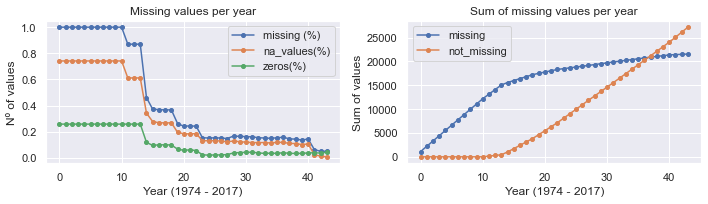

In [85]:
cols = [2,3,4]
fig = plt.figure(figsize=(10,3), tight_layout=True)
ax0, ax1 = [fig.add_subplot(1,2,i) for i in [1,2]]
missing.iloc[:, cols].plot(marker='o', ms=4, title='Missing values per year', ax=ax0)
ax0.set(ylabel='Nº of values', xlabel='Year (1974 - 2017)')
missing.cumsum().iloc[:, :2].plot(marker='o', ms=4, title='Sum of missing values per year', ax=ax1)
ax1.set(ylabel='Sum of values', xlabel='Year (1974 - 2017)')
plt.show()

Conclusion:
    After the data cleaning process, each year is missing at least 85% of its values until the 13th indexed year, but miss only less then 40% from then on. So we can safely exclude the values for years before the 14th indexed year (1987).

### 5.2 Número de entradas vazias e tamanho de cada série

In [67]:
stats = []
for key in ts_dict.keys():
    ij = ts_dict[key]
    n = len(ij)
    n_empty = ij[target].isna().sum()
    p_empty = n_empty / n
    info = key.split('-')
    city, product = info[0], '-'.join(info[1:3])
    stats.append([ city, product, n, n_empty, p_empty ])            
            
stats = pd.DataFrame(stats, columns=['city', 'product', 'n', 'n_empty', 'p_empty'])

In [71]:
stats['n'].unique()

array([44, 33], dtype=int64)

In [68]:
stats.describe()

,n,n_empty,p_empty
count,1712.000000,1712.000000,1712.000000
mean,43.074766,22.800818,0.518200
std,3.054007,17.328151,0.393822
min,33.000000,0.000000,0.000000
25%,44.000000,0.000000,0.000000
50%,44.000000,19.000000,0.431818
75%,44.000000,44.000000,1.000000
max,44.000000,44.000000,1.000000


#### Resultados:
* Número de cidades: 144
* Número de produtos 12
* Número de tipos de produtos: 3
* Número total de séries temporais: 1584
* Nùmero de anos disponíveis: 44 (1974 - 2017),
* Número médio de anos vazios: 22,6
* Porcentagem média de entradas vazias por série: 52% (22,6/44)
* 50% das séries possuem mais que 43% de entradas vazias.

Produtos: 'Others', 'Rice', 'Beans', 'Cassava', 'Corn', 'Soy', 'Sorghum', 'Cocoa', 'Palm oil', 'Açaí', 'Livestock'

Tipos de Produtos: 'temporary', 'permanent', 'pasture'

In [10]:
sum([ts_i[key]['area'].isna().sum()==len(ts_i[key]) for key in ts_i.keys()]) / len(ts_i)

0.25817757009345793

### 5.3 Visualizando vazios por séries temporais por quantidade de entradas

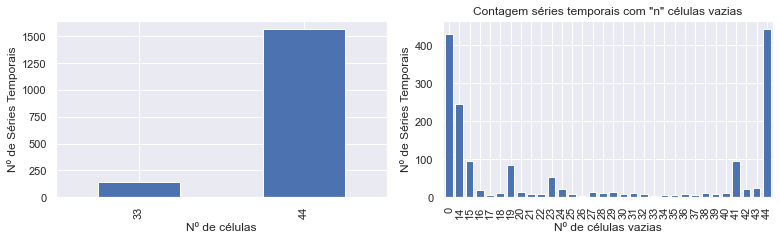

In [11]:
fig = plt.figure(figsize=(11,3.5), tight_layout=True)
axes = [fig.add_subplot(1,2,i) for i in [1,2]]
stats['n'].value_counts().sort_values().plot.bar(ax=axes[0])
stats['n_empty'].value_counts().sort_index().plot.bar(ax=axes[1], width=.75)#, marker='x', ms=7)
axes[0].set_ylabel('Nº de Séries Temporais')
axes[0].set_xlabel('Nº de células')
axes[1].set_ylabel('Nº de Séries Temporais')
axes[1].set_xlabel('Nº de células vazias')
plt.title('Contagem séries temporais com "n" células vazias'); plt.show()

Resultado: Maioria das séries possui 44 entradas porém algumas séries possuem 33 entradas.
Obs: Algumas Séries não possuem entradas (zero entradas) mas foram excluídas da contagem.

### Counting missing series per city

In [63]:
n_city_series = pd.Series([data[data['city_code']==uni_city].groupby(['city_code', 'product', 'product_type']).sum().shape[0] for uni_city in data['city_code'].unique()], index = data['city_code'].unique())
n_city_series.value_counts()

12    138
11      5
1       1
dtype: int64

#### Missing values per city_code:
* 138 cities have values for all 12 types-products
* 5 cities have values for 11 types-products
* 1 city have values for only 1 type-product

### Series count per number of missing values

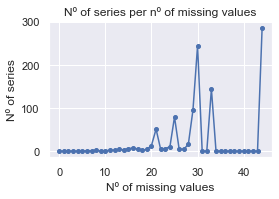

In [66]:
empty_cnt = pd.Series([len(series[key]) for key in series.keys()]).value_counts();
empty_cnt = pd.concat([empty_cnt, pd.Series(np.zeros(44))], 1).fillna(0)[0]

fig = plt.figure(figsize=(4, 2.5))
empty_cnt.plot(marker='o', ms=4)
plt.title('Nº of series per nº of missing values')
plt.ylabel('Nº of series')
plt.xlabel('Nº of missing values')

plt.show()

### 2.1 Lidando com dados nulos

#### Null values count per serie

In [72]:
null_stats = []
for key in series.keys():
    y = series[key][target]
    n_null = (y==0).sum()
    n = len(y)
    p_null = n_null / n
    null_stats.append([key, n_null, n, p_null])
null_stats = pd.DataFrame(null_stats, columns=['city-product', 'n_null', 'n', 'p_null'])

#### Percentiles of series per nº of null values

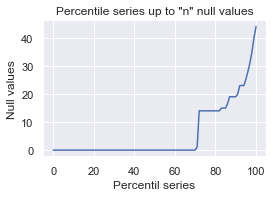

In [78]:
fig = plt.figure(figsize=(4, 2.5))
plt.plot(np.percentile(null_stats['n_null'], range(101)))
plt.title('Percentile series up to "n" null values')
plt.xlabel('Percentil series')
plt.ylabel('Null values')
plt.show()

#### 2.4 Counting null values per product_type on the testset (2016 and 2017)

In [33]:
null_prod_stats = []
for indexes in [prodtype_indexes, prod_indexes]:
    type_stats = []
    for key in indexes:
        type_area = Y_e[indexes[key]]
        n_null = (type_area==0).sum()
        n = len(type_area.dropna())
        p = n_null / n
        type_stats.append([key, n, n_null, n-n_null, n_null/n])
    null_prod_stats.append(pd.DataFrame(type_stats, columns=['product_type', 'n', 'n_null', 'n_non_null', 'p_null']))
eval_prod_stats = pd.concat(null_prod_stats)
eval_prod_stats

,product_type,n,n_null,n_non_null,p_null
0,temporary,1284,79,1205,0.061526
1,permanent,654,10,644,0.015291
2,pasture,288,0,288,0.000000
0,Rice,190,0,190,0.000000
1,Beans,230,0,230,0.000000
2,Cassava,275,0,275,0.000000
3,Corn,251,0,251,0.000000
4,Soy,50,0,50,0.000000
5,Cocoa,115,0,115,0.000000
6,Palm oil,51,0,51,0.000000


### 5.4 Visualizando conjuntos de séries temporais por cidade

No handles with labels found to put in legend.


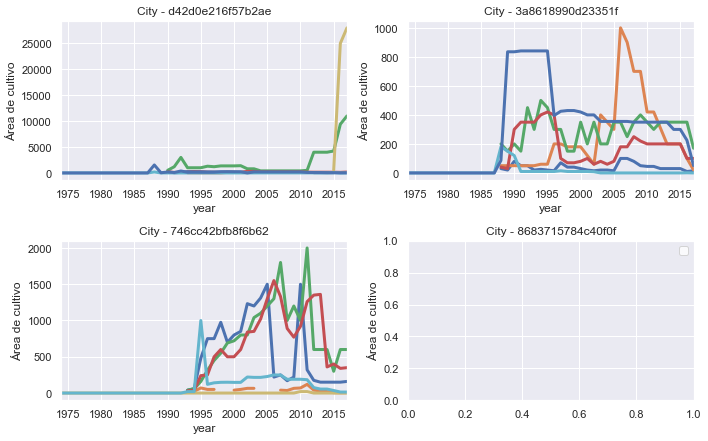

In [13]:
n_cities = 4

fig = plt.figure(figsize=(10,15), tight_layout=True)
axes = [fig.add_subplot(5, 2, i) for i in range(1, n_cities+1)]

for city, ax in zip(np.random.choice(cities, n_cities), axes):
    i = ts_ij[city]
    ax.set(title=f'City - {city}', ylabel='Área de cultivo')
    for product in prods:
        
        if (product in i.keys()) and product!='Livestock' :
            ij = i[product]
            if len(ij): 
                points = ij[target]; points.name=product
                points.plot(ax=ax, lw=3, label=product)

ax.legend(loc='best', facecolor=(1,1,1,0.2))
plt.savefig('plots/Séries Temporais por Cidade.png')
plt.show()

### 5.5 Visualizando conjuntos de séries temporais por produto

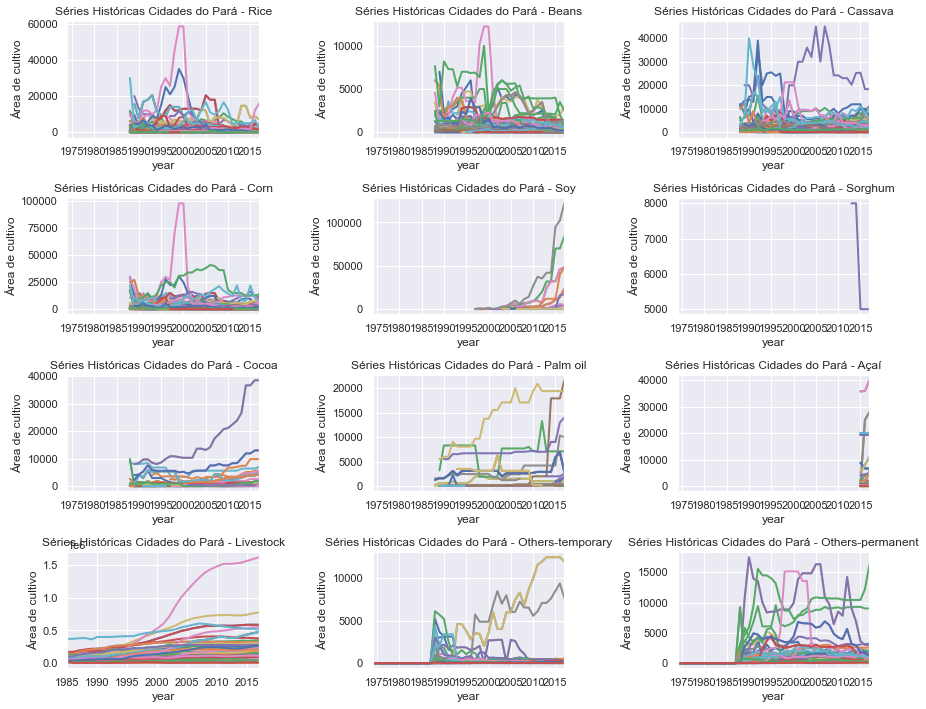

In [14]:
fig = plt.figure(figsize=(13,12), tight_layout=True)
axes = [fig.add_subplot(5, 3, i) for i in range(1, len(prods)+1)]

for city in np.random.choice(cities, len(cities)):
    i = ts_ij[city]
    for product, ax in zip(prods, axes):
        ax.set(title='Séries Históricas Cidades do Pará - ' + product, ylabel='Área de cultivo')
        if product in i.keys():
            ij = i[product]
            if len(ij): 
                ij[target].plot(ax=ax, lw=2)
# ax.legend(loc='best')
plt.savefig('plots/Séries Temporais por Produto-Tipo.png')
plt.show()

## "Others" product type exploration

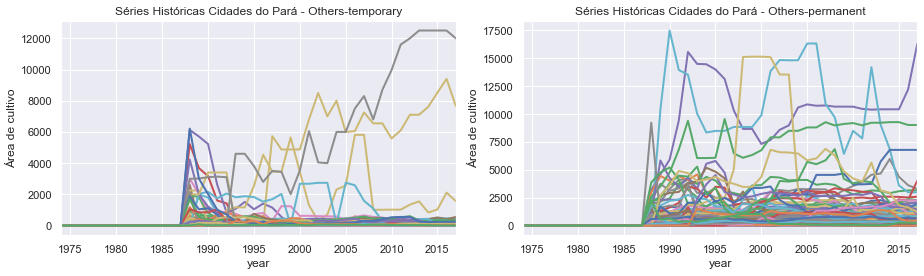

In [26]:
fig = plt.figure(figsize=(13,4), tight_layout=True)
axes = [fig.add_subplot(1, 2, i) for i in range(1, 3)]

null_count = {}
for city in cities:
    i = ts_ij[city]
    for product, ax in zip(prods[-2:], axes):
        ax.set(title='Séries Históricas Cidades do Pará - ' + product, ylabel='Área de cultivo')
        if product in i.keys():
            ij = i[product]
            if len(ij):
                null_cnt = (ij[target]==0).sum()
                n = len(ij[target].dropna())
                p = null_cnt / n
                null_count[city+'-'+product]=[null_cnt, n, p]
                ij[target].plot(ax=ax, lw=2)
# ax.legend(loc='best')
plt.savefig('plots/Séries Temporais por Produto-Tipo.png')
plt.show()

In [36]:
others_stts = pd.DataFrame(null_count, index=['null_count', 'count', 'null_p']).T

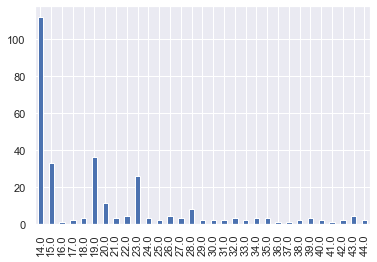

In [47]:
others_stts['null_count'].value_counts().sort_index().plot.bar()

### Setting integer year index

int_series = {}
for key in keys:
    int_series[key] = series[key].set_index(pd.DatetimeIndex(series[key]['year'].astype('datetime64[Y]')).year)[target]

#### Setting label encoded index

In [10]:
lab_series = {}
for key in keys:
    lab_series[key] = series[key].set_index(LE.transform(series[key]['year']))[target]

#### Settings train and test series

In [11]:
tt_series = {}
for key in keys:
    tt_series[key] = {'train': dt_series[key][:'2015'].copy(), 'test': dt_series[key]['2016':].copy()}

In [12]:
tt_lab_series = {}
for key in keys:
    msk = lab_series[key].index.isin([42, 43])
    tt_lab_series[key] = {'train': lab_series[key][msk==False].copy(), 'test': lab_series[key][msk].copy()}

#### Extracting full series keys

In [13]:
full_keys = []
for key in keys:
    if len(tt_lab_series[key]['train'])==42 and len(tt_lab_series[key]['test'])==2:        
        full_keys.append(key)

#### Concating full time series

In [14]:
X = pd.concat([lab_series[key] for key in full_keys], 1); X.columns = full_keys

In [15]:
Xt = X.loc[:41]
Xe = X.loc[[42, 43]]